# Reproduction: Alain & Bengio. (2016). [Understanding intermediate layers using linear classifier probes](https://arxiv.org/abs/1610.01644).

They show that there is progressively more linear separation between classes as you proceed through a deep neural network.

I also want to investigate how linear separability changes in each layer with the number of training epochs.

## Experimental setup

Conditions:
 - Train the network for 30 epochs and record weights after each epoch
 - For each training epoch, probe each layer in the network (see _Network structure_ below) for linear separability, as measured by the accuracy of the optimized probe on the test data.

Data:
 - CIFAR-10: 50k training; 10k test; 10 classes
 - Transformations:
    - Crop out the central 28 x 28 patch (from the original 32 x 32)
    - Normalize by subtracting the mean and dividing by the standard deviation independently for each image

Network structure:
 - Alexnet:
    - 28 x 28 inputs
    - 2 x (convolution + ReLU → max-pool → local-response-normalization) layers
    - 2 x convolution only layers
    - 1 x (convolution + ReLU → max-pool) layer
    - Followed by two fully connected layers with 512 hidden units each
    - Finally a 10-way linear layer is used for prediction

Regularization:
 - No weight decay, dropout, or other regularization

Optimizer: SGD with
 - momentum = 0.9
 - initial learning rate = 0.01
 - decay factor = 0.95 per epoch

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load and preprocess CIFAR-10 data

In [3]:
# Transformations for the training and test sets
class PerImageStandardize:
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        # x: Tensor [C, H, W] in float
        mean = x.mean()
        std = x.std().clamp_min(1.0 / (x.numel() ** 0.5))
        x = (x - mean) / std
        return x


transform_data = transforms.Compose([
    transforms.CenterCrop(28),
    transforms.ToTensor(),  # Changes shape from (height, width, channels) to (channels, height, width).
    PerImageStandardize(),
])

train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_data
)

test_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_data
)

print(f"Number of training samples: {len(train_set)}")
print(f"Number of test samples: {len(test_set)}")

Number of training samples: 50000
Number of test samples: 10000


## Model: AlexNet

I also tried this with an MLP (2 hidden layers; 512 hidden units per layer), but didn't get better than ~55% test accuracy, so dropped it.

In [4]:
class AlexNet(nn.Module):
    name = 'alexnet'
    
    def __init__(self):
        super(AlexNet, self).__init__()

        self.conv_layers = nn.Sequential(
            
            nn.Conv2d(3, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2.0),

            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2.0),

            nn.Conv2d(128, 192, kernel_size=3, padding=1),
            nn.Conv2d(192, 192, kernel_size=3, padding=1),
            nn.Conv2d(192, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.fc_layers(x)
        return x

#import torchinfo
#torchinfo.summary(AlexNet(), input_size=(1, 3, 28, 28), verbose=2)  # batch size included

## Training

In [ ]:
# Set this to True to retrain the base AlexNet model, before attaching
# linear probes to it.
RETRAIN = False

In [5]:
def train_one_epoch(model, train_loader, loss_function, optimizer, scheduler):
    '''
    Handle a single training pass, including forward and backward propagation,
    loss calculation, gradient optimization, and accumulation of training metrics.
    '''
    # Set the model to training mode
    model.train()
    # Initialize metrics
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    for inputs, labels in train_loader:
        # Load data
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        # Update training loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
    scheduler.step()
    # Return average metrics
    epoch_loss = running_loss / total_samples
    epoch_accuracy = 100 * correct_predictions / total_samples
    return epoch_loss, epoch_accuracy

In [6]:
def evaluate_model(model, data_loader, loss_function):
    '''
    Place the model in evaluation mode, disable gradient calculations,
    and compute average loss and accuracy on a given dataset.
    '''
    model.eval()  # Set the model to evaluation mode

    # Init metrics
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():  # Disable gradient calculations, i.e. freeze the model parameters
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            # Forward pass
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            # Update metrics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / total_samples
    accuracy = 100 * correct_predictions / total_samples
    return avg_loss, accuracy

In [7]:
def train_model(model, batch_size = 128, num_workers = 0, num_epochs = 100, save_state = True, overwrite = False):
    '''
    Setup data loaders, model, and optimizer. Then, orchestrate model training
    over multiple epochs, calling `train_one_epoch` and `evaluate_model` to
    track both training and validation performance.
    '''
    import torch.optim as optim
    from torch.optim.lr_scheduler import ExponentialLR
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    validation_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    model.to(DEVICE)
    print(f"Model moved to device: {DEVICE}")
    
    # Choose the loss function: cross-entropy loss for classification task
    loss_function = nn.CrossEntropyLoss()
    
    # Choose the optimizer, for example `Adam` or `SGD` with appropriate learning rate.
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = ExponentialLR(optimizer, gamma=0.95)
    
    def _save_state(epoch):
        nonlocal model, save_state, overwrite
        if not save_state:
            return
        path = f"2025-12-26-reproduce-alain-2016-understanding/{model.name}-epoch-{epoch:03d}.pt"
        try:
            open(path, 'r')
        except FileNotFoundError:
            pass
        else:
            if not overwrite:
                import errno
                raise FileExistsError(
                    errno.EEXIST,
                    "File already exists (and overwrite not allowed)",
                    path,
                )
        torch.save(model.state_dict(), path)

    _save_state(epoch=0)
    print("Starting training...")
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'validation_loss': [],
        'validation_accuracy': [],
    }
    try:
        for epoch in range(num_epochs):
            train_loss, train_accuracy = train_one_epoch(model, train_loader, loss_function, optimizer, scheduler)
            validation_loss, validation_accuracy = evaluate_model(model, validation_loader, loss_function)
            _save_state(epoch=epoch + 1)
            history['train_loss'].append(train_loss)
            history['train_accuracy'].append(train_accuracy)
            history['validation_loss'].append(validation_loss)
            history['validation_accuracy'].append(validation_accuracy)
            print(f"Completed epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%")
    except KeyboardInterrupt:
        print('Interrupted')

    print("Training finished.")
    return history

In [8]:
num_training_epochs = 30
if RETRAIN:
    model = AlexNet()
    train_model(model, num_epochs=num_training_epochs, overwrite=True)

## Linear probe

* Load model state
* Do surgery to install a linear probe
* Optimize the probe
* Evaluate validation accuracy

In [9]:
def load_model(model_class, epoch):
    model = AlexNet()
    path = f"2025-12-26-reproduce-alain-2016-understanding/{model.name}-epoch-{epoch:03d}.pt"
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint)
    model.to(DEVICE)
    return model

In [10]:
class SurgeryModel(nn.Module):
    def __init__(self, backbone, tapped_layer_name):
        super().__init__()
        self.backbone = backbone
        self.tapped_layer_name = tapped_layer_name
        self.activation = {}

        # Install hook
        tapped_layer = dict(self.backbone.named_modules())[tapped_layer_name]
        tapped_layer.register_forward_hook(self._hook)

        # Infer number of classes
        m = list(backbone.modules())[-1]
        if not isinstance(m, torch.nn.Linear):
            raise TypeError("Expected the final layer of `backbone` to be torch.nn.Linear")
        self.num_classes = m.out_features

        # Placeholder; set after we see data once
        self.head = None

    def _hook(self, module, inp, out):
        self.activation[self.tapped_layer_name] = out

    def _init_head_if_needed(self):
        if self.head is not None:
            return
        feat = self.activation[self.tapped_layer_name]
        if feat.dim() == 4:  # [B, C, H, W]
            # Convolutional layer: flatten before attaching linear layer
            c = feat.shape[1]
            self.head = nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Flatten(),
                nn.Linear(c, self.num_classes),
            )
        else:  # [B, D]
            d = feat.shape[1]
            self.head = nn.Linear(d, self.num_classes)
        self.head = self.head.to(feat.device)

    def forward(self, x):
        _ = self.backbone(x)
        self._init_head_if_needed()
        feat = self.activation[self.tapped_layer_name]
        return self.head(feat)

In [11]:
# Probe each layer in order. We expect classes to be progressively more linearly
# separable as we go deeper into the network. Note that probing layer X means attaching
# the probe to the output of X.
def iter_leaf_modules_in_tree_order(model: nn.Module):
    for name, m in model.named_modules():
        if name == "":
            continue  # skip the root module itself
        if len(list(m.children())) == 0:  # leaf = no submodules
            yield name, m

In [ ]:
num_epochs = 10  # Number of epochs for probe optimization

# These parameters are the same as the ones used during training of the original model
batch_size = 128
num_workers = 0

# Save probe results to CSV
import csv
csv_file = open('2025-12-26-reproduce-alain-2016-understanding/probe-results.csv', 'at')
csv_writer = csv.writer(csv_file)

for training_epoch in range(num_training_epochs + 1):
    original_model = load_model(AlexNet, training_epoch)
    print(f"Probing all layers for training epoch {training_epoch} in order.")
    print("Probing layer X means attaching the linear probe to the output of X.")
    
    for probe_layer_index, (probe_layer, probe_module) in enumerate(iter_leaf_modules_in_tree_order(original_model)):
        print(f"\nProbing {probe_layer}:", probe_module)
    
        # Create probed model; freeze non-probe weights
        model_with_probe = SurgeryModel(original_model, probe_layer)
        for p in model_with_probe.backbone.parameters():
            p.requires_grad = False
    
        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        validation_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
            
        model_with_probe.to(DEVICE)
            
        loss_function = nn.CrossEntropyLoss()
        
        # Init optimizer; requires initializing the surgery model with a dummy input
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 28, 28, device=DEVICE)
            out = model_with_probe(dummy)
            num_classes = out.shape[1]
        optimizer = torch.optim.SGD(model_with_probe.head.parameters(), lr=0.01, momentum=0.9)
        
        from torch.optim.lr_scheduler import ExponentialLR
        scheduler = ExponentialLR(optimizer, gamma=0.95)
    
        # Optional sanity check: record weights to make sure they remain frozen
        SANITY_CHECK = False
        if SANITY_CHECK:
            import copy
            _weights_before = {
                name: p.detach().clone()
                for name, p in model_with_probe.named_parameters()
            }
        
        for epoch in range(num_epochs + 1):
            if epoch > 0:
                train_loss, train_accuracy = train_one_epoch(model_with_probe, train_loader, loss_function, optimizer, scheduler)
            else:
                train_loss = torch.inf
                train_accuracy = 0
            validation_loss, validation_accuracy = evaluate_model(model_with_probe, validation_loader, loss_function)
            print(f"  probe optimization epoch {epoch}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%")
    
        if SANITY_CHECK:
            print('  weight change sanity check:')
            for name, p in model_with_probe.named_parameters():
                print(f"   - {name}:", 'same' if torch.equal(_weights_before[name], p) else 'CHANGED')

        csv_writer.writerow([training_epoch, probe_layer_index, probe_layer, validation_loss, validation_accuracy])
        csv_file.flush()

    del original_model

## Plot linear probe results

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Read CSV
df = pd.read_csv("2025-12-26-reproduce-alain-2016-understanding/probe-results.csv")

# Name the layers for the x-axis labels
nn_layers = [
    'Conv2d', 'ReLU', 'MaxPool2d', 'LocalResponseNorm',
    'Conv2d', 'ReLU', 'MaxPool2d', 'LocalResponseNorm',
    'Conv2d', 'Conv2d', 'Conv2d', 'ReLU', 'MaxPool2d',
    'Linear', 'ReLU', 'Linear', 'ReLU', 'Linear',
]

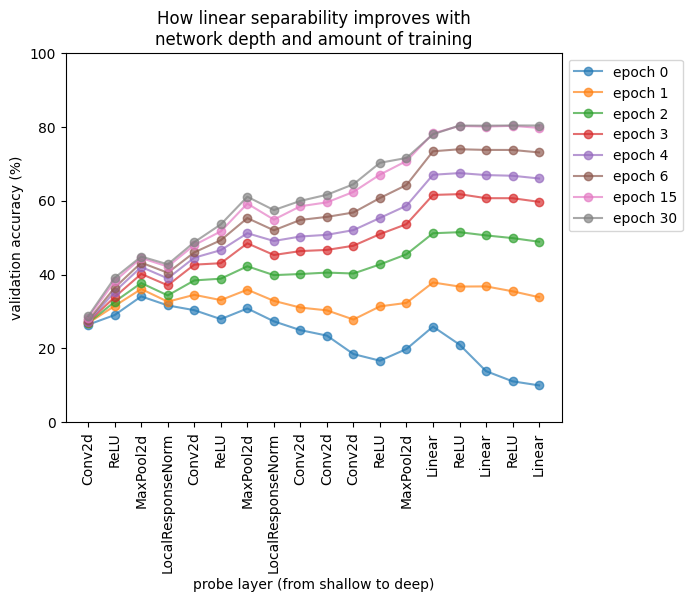

In [3]:
plt.figure()
plt.title("How linear separability improves with\nnetwork depth and amount of training")
plt.xlabel("probe layer (from shallow to deep)")
plt.ylabel("validation accuracy (%)")

for epoch in [0, 1, 2, 3, 4, 6, 15, 30]:
    df_filt = df[df["training epochs"] == epoch]
    plt.plot(df_filt["probe layer index"], df_filt["validation accuracy"], 'o-', label=f"epoch {epoch}", alpha=0.667)
plt.xticks(range(len(nn_layers)), nn_layers, rotation=90)
plt.ylim(0, 100)
plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))
plt.show()

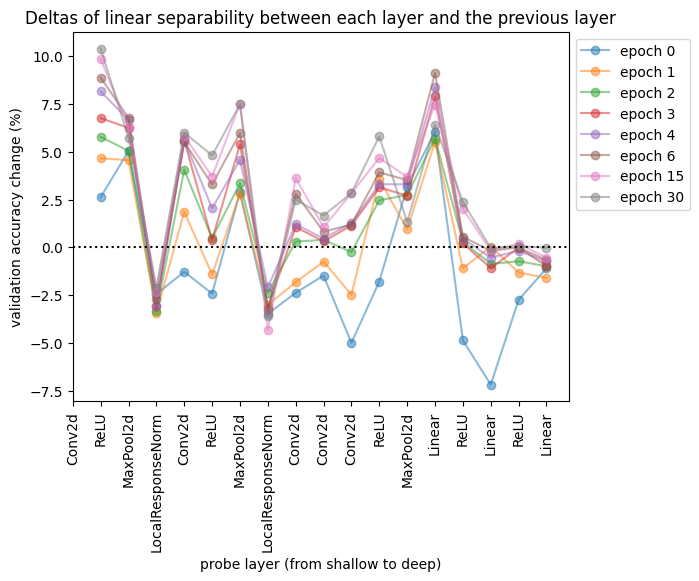

In [4]:
plt.figure()
plt.title("Deltas of linear separability between each layer and the previous layer")
plt.xlabel("probe layer (from shallow to deep)")
plt.ylabel("validation accuracy change (%)")

for epoch in [0, 1, 2, 3, 4, 6, 15, 30]:
    df_filt = df[df["training epochs"] == epoch]
    plt.plot(
        df_filt["probe layer index"].array[1:],
        df_filt["validation accuracy"].array[1:] - df_filt["validation accuracy"].array[:-1],
        'o-', label=f"epoch {epoch}", alpha=0.5)
plt.xticks(range(len(nn_layers)), nn_layers, rotation=90)
plt.axhline(0, linestyle=':', color='k')
plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))
plt.show()

## Interesting features

* Even with no training (epoch 0; random initialization), the first convolution layer,
  ReLU, and max-pooling improve linear separability.
* The local response normalization layers always reduce linear separability, regardless
  of depth and amount of training.
* After only 3 epochs of training, each layer already improves linear separability (except
  for the max-pooling layers).
* After 15 epochs of training the first convolutional layer (with its ReLU and max-pool)
  has converged (negligible further improvement) but the later convolutional layers are still
  improving. However, the fully connected layers at the end have also already converged. So,
  the middle is still improving but without improving overall linear separability.
* The second fully connected layer + ReLU just barely helps improve separability, and only after
  a lot of training. It's detrimental earlier on.
* The first fully connected layer helps even without any training (epoch 0) but only if you
  don't use a ReLU after it. After epoch 2, the ReLU also improves linear separability.

## New hypotheses:

* The network will do better overall if we remove the local response normalization layers.
  * Update: Partially confirmed.
  * Accuracy improves significantly faster when removing the local response normalization layers,
    but ultimately, it still converges to the same accuracy.
  * The results are more complicated when using loss rather than accuracy as the metric.
  * See [2026-01-07-train-and-compare-modified-alexnet.ipynb](2026-01-07-train-and-compare-modified-alexnet.ipynb) for details.
* The network will create linearly separable features in the convolutional layers even
  if we train on randomly labelled data (and then validate using correctly labelled data).
  Random training labels would force the network to memorize the data set, but as per
  [zhang-2017-understanding], networks trained with stochastic gradient descent might be
  able to generalize anyway. So, how does linear separability improve with more training
  on randomly labelled training data, and then fitting a linear probe? Hypothesis: it will
  do worse than with labelled data but it will do better than without the randomized training
  phase, since the network (especially convolutional layers) will still learn good features.
  Secondary hypothesis: the fully connected layers will overfit on the randomized labels and
  not generalize well — i.e., not be linearly separable w.r.t. the correct labels in the
  validation data.